In [34]:
import snscrape.modules.twitter as sntwitter
import pandas as pd
from torchtext.data.utils import get_tokenizer
import torch
import spacy
import numpy as np
import torchtext.vocab
from torchtext.datasets import AG_NEWS
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator, GloVe
from datasets import load_dataset
from torch.utils.data import Dataset, DataLoader
from torchtext import data
from transformers import BertTokenizer
import torch
import torch.nn as nn
from sentiment_model.data_utils.tweet_dataset import TweetDataset, pad_batch, pad_batch_inference
from tqdm.notebook import tqdm
from sentiment_model.model import SentimentNet
from sentiment_model.data_utils.tweet_dataset import TweetDatasetInference
from sentiment_model.data_utils.metrics import accuracy
from torch.nn import Softmax

In [2]:
def get_tweets(keyword, start_date, end_date, lang='en', max_tweets=1000):
    attributes = ['id', 'date', 'rawContent', 'sourceLabel', 'user']
    tweet_list = []

    # can use from: since: lang: until:
    p_bar = tqdm(total=max_tweets)

    scrape_str = "{} lang:{} since:{} until:{}".format(keyword, lang, start_date, end_date)
    #'Milk lang:en since:2020-01-01 until:now'
    for i, tweet in enumerate(sntwitter.TwitterSearchScraper(scrape_str).get_items()):

        if i > max_tweets:
            break

        tweet_list.append([tweet.__dict__[a] if a!="user" else tweet.__dict__[a].username \
                           for a in attributes ])

        p_bar.update(1)

    tweet_df = pd.DataFrame(tweet_list, columns=attributes)
    return tweet_df

In [3]:
def load_model_for_inference(model_file, checkpoint_path = "../sentiment_model/checkpoints/", device="cpu"):
    checkpoint = torch.load(str(checkpoint_path) + model_file)
    sentiment_net = SentimentNet(vocab_size=1193516, embedding_dim=50)
    sentiment_net.load_state_dict(checkpoint['model_state_dict'])
    sentiment_net.to(device)
    sentiment_net.eval()
    return sentiment_net

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
sentiment_net = load_model_for_inference(model_file="vivid-thunder-47/vivid-thunder-47-epoch-7.pth", device=device)

In [4]:
glove_twitter = GloVe(name="twitter.27B", dim=50,)
tweet_data = load_dataset("SetFit/tweet_sentiment_extraction")
tweet_dataset = TweetDataset(split='train', pretrained_vecs=glove_twitter)


Using custom data configuration SetFit--tweet_sentiment_extraction-bee4b4571daa6a0e
Reusing dataset json (C:\Users\20172613\.cache\huggingface\datasets\json\SetFit--tweet_sentiment_extraction-bee4b4571daa6a0e\0.0.0\ac0ca5f5289a6cf108e706efcf040422dbbfa8e658dee6a819f20d76bb84d26b)


  0%|          | 0/2 [00:00<?, ?it/s]

Using custom data configuration SetFit--tweet_sentiment_extraction-bee4b4571daa6a0e
Reusing dataset json (C:\Users\20172613\.cache\huggingface\datasets\json\SetFit--tweet_sentiment_extraction-bee4b4571daa6a0e\0.0.0\ac0ca5f5289a6cf108e706efcf040422dbbfa8e658dee6a819f20d76bb84d26b)


  0%|          | 0/2 [00:00<?, ?it/s]

In [5]:
tweet_df = get_tweets("Milk", "2020-01-30", "now", max_tweets=1000)
sample_tweet = tweet_df['rawContent'][1]
sample_tweet

  0%|          | 0/1000 [00:00<?, ?it/s]

'@WalmartCanada please explain how all @silk_canada products are 2/$7 and up until now Next Milk was always included in that deal and now it’s almost $5 for one? This is crazy @LoveMySilk https://t.co/gb1t4Qu0ge'

In [13]:
inf_data = TweetDatasetInference(tweet_df["rawContent"], train_pipeline=tweet_dataset.text_pipeline)

In [46]:
test_loader = DataLoader(inf_data, batch_size=1024, shuffle=False, collate_fn=pad_batch_inference)

def run_inference(model, data_loader):

    results = []

    soft_max = Softmax(dim=1)

    with torch.no_grad():
        p_bar = tqdm(total=len(data_loader.dataset))
        for batch_idx, (data, text_lengths) in enumerate(data_loader):
            # For assignment 3.2, we need to know the lengths of the targets

            data, text_lengths = data.to(device), text_lengths.to(device)

            # Forward pass
            output = model(data, text_lengths)
            prob_out = soft_max(output, )
            results.extend(prob_out.tolist())
            p_bar.update(data.shape[0])

    return np.array(results)

In [47]:
results = run_inference(sentiment_net, test_loader)

  0%|          | 0/1001 [00:00<?, ?it/s]

In [49]:
class_labels = np.argmax(results, axis=1)
labels = ['negative', 'neutral', 'positive']
for tweet, class_label in zip(tweet_df['rawContent'], class_labels):
    print(tweet)
    print(f"sentiment: {labels[class_label]}\n")

i never even knew this was a thing until now,,,,, COLD! MILK! SUPREMACY!
sentiment: negative

@WalmartCanada please explain how all @silk_canada products are 2/$7 and up until now Next Milk was always included in that deal and now it’s almost $5 for one? This is crazy @LoveMySilk https://t.co/gb1t4Qu0ge
sentiment: neutral

@Milk_6815 @SeizonNFT I had a great week until now :)
Hbu?
sentiment: positive

Guys, I fucked up...I drank milk yesterday but it didn't hit me until now...I have been in the bathroom for 20 minutes now and I can hear my team lead calling for me https://t.co/3uDOuc8gll
sentiment: neutral

@Hatofulloid @kenjisaurr @KotomineSalad Did you really not notice until now
sentiment: neutral

@hilltopgina No one's ever actually looked into how much our consumption of mammal udder juice contributes to growing up big and strong, but we just roll with it anyway.  Until now.

If Milk Commercials Were Honest - Honest Ads https://t.co/QLjIPHEn6D 

👇👇👇👇👇👇👇👇👇👇👇👇👇👇👇👇👇
sentiment: neutra

In [30]:
input_tweet = torch.tensor(tweet_dataset.text_pipeline(sample_tweet))
sentiment_net(input_tweet)

TypeError: forward() missing 1 required positional argument: 'text_lengths'

,id,date,rawContent,sourceLabel,user
0,1583342506485624832,2022-10-21 06:20:45+00:00,"i never even knew this was a thing until now,,...",Twitter for Android,lunaillumina
1,1583111510226010112,2022-10-20 15:02:51+00:00,@WalmartCanada please explain how all @silk_ca...,Twitter for iPhone,_leah2
2,1583096022636539904,2022-10-20 14:01:18+00:00,@Milk_6815 @SeizonNFT I had a great week until...,Twitter for iPhone,oliver65233
3,1583041979016892417,2022-10-20 10:26:33+00:00,"Guys, I fucked up...I drank milk yesterday but...",Twitter for Android,JayDoh20
4,1582922609616117760,2022-10-20 02:32:14+00:00,@Hatofulloid @kenjisaurr @KotomineSalad Did yo...,Twitter for iPhone,PenguinMilkTea
...,...,...,...,...,...
996,1430920100878635011,2021-08-26 15:48:31+00:00,@ogdurb so you’ve been drinking cow milk up un...,Twitter for iPhone,chelseanwosu
997,1430877881295462412,2021-08-26 13:00:45+00:00,i never get palpitations from milk tea until n...,Twitter for iPhone,carliemanayan
998,1430727836696973312,2021-08-26 03:04:32+00:00,Lol all these people stressing over how danger...,Twitter for iPhone,Chrismorrow757
999,1430701937180114947,2021-08-26 01:21:37+00:00,"So I was eating a really spicy sambal chicken,...",Twitter for iPhone,r4y_666


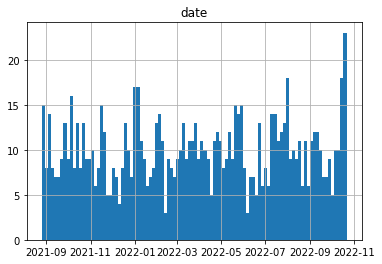

In [16]:
tweet_df.hist("date", bins=100)
tweet_df

[2,
 202,
 3375,
 128,
 77,
 2,
 6378,
 72,
 1,
 28,
 87,
 720,
 112,
 413,
 3988,
 95,
 247,
 15010,
 37,
 47,
 1380,
 28,
 112,
 35,
 667,
 1147,
 208,
 9,
 39,
 98,
 16,
 55,
 34,
 674,
 2,
 10]

In [49]:
import re

def process_token(token):

    # Different regex parts for smiley faces
    eyes = r"[8:=;]"
    nose = r"['`\-]?"

    def re_sub(pattern, repl, text):
        return re.sub(pattern, repl, text)

    # Match url
    token = re_sub(r"https?:\/\/\S+\b|www\.(\w+\.)+\S*", "<url>", token)

    # Match user
    token = re_sub(r"@\w+", "<user>", token)

    # Match smileys
    token = re_sub(r"{}{}[)dD]+|[)dD]+{}{}".format(eyes, nose, nose, eyes), "<smile>", token)
    token = re_sub(r"{}{}p+".format(eyes, nose), "<lolface>", token)
    token = re_sub(r"{}{}\(+|\)+{}{}".format(eyes, nose, nose, eyes), "<sadface>", token)
    token = re_sub(r"{}{}[\/|l*]".format(eyes, nose), "<neutralface>", token)
    token = re_sub(r"<3","<heart>", token)

    # Match number
    token = re_sub(r"[-+]?[.\d]*[\d]+[:,.\d]*", "<number>", token)

    # Match hashtag
    token = re_sub(r"#", "<hashtag>", token)
    return token

def process_token_list(tokens):
    return [process_token(t) for t in tokens]


In [52]:
tk = get_tokenizer("spacy", language="en_core_web_sm")
tk_tweet = tk(sample_tweet)
tk_tweet

['@WalmartCanada',
 'please',
 'explain',
 'how',
 'all',
 '@silk_canada',
 'products',
 'are',
 '2/$7',
 'and',
 'up',
 'until',
 'now',
 'Next',
 'Milk',
 'was',
 'always',
 'included',
 'in',
 'that',
 'deal',
 'and',
 'now',
 'it',
 '’s',
 'almost',
 '$',
 '5',
 'for',
 'one',
 '?',
 'This',
 'is',
 'crazy',
 '@LoveMySilk',
 'https://t.co/gb1t4Qu0ge']

In [53]:
process_token_list(tk_tweet)

['<user>',
 'please',
 'explain',
 'how',
 'all',
 '<user>',
 'products',
 'are',
 '<number>/$<number>',
 'and',
 'up',
 'until',
 'now',
 'Next',
 'Milk',
 'was',
 'always',
 'included',
 'in',
 'that',
 'deal',
 'and',
 'now',
 'it',
 '’s',
 'almost',
 '$',
 '<number>',
 'for',
 'one',
 '?',
 'This',
 'is',
 'crazy',
 '<user>',
 '<url>']

In [58]:

process_token_list(tk("@dlsajfl :p dpsja b/b 134 sup :-)))))"))
#process_tweet("#JaJA")

['<user>',
 '<lolface>',
 'dpsja',
 'b',
 '/',
 'b',
 '<number>',
 'sup',
 '<smile>',
 ')',
 ')']

In [12]:
re.findall(r"@\w+", sample_tweet)

['@WalmartCanada', '@silk_canada', '@LoveMySilk']

In [ ]:
FLAGS = re.MULTILINE | re.DOTALL

def hashtag(text):
    text = text.group()
    hashtag_body = text[1:]
    if hashtag_body.isupper():
        result = "<hashtag> {} <allcaps>".format(hashtag_body)
    else:
        result = " ".join(["<hashtag>"] + re.split(r"(?=[A-Z])", hashtag_body, flags=FLAGS))
    return result

def allcaps(text):
    text = text.group()
    return text.lower() + " <allcaps>"


def tokenize(text):
    # Different regex parts for smiley faces
    eyes = r"[8:=;]"
    nose = r"['`\-]?"

    # function so code less repetitive
    def re_sub(pattern, repl):
        return re.sub(pattern, repl, text, flags=FLAGS)

    text = re_sub(r"https?:\/\/\S+\b|www\.(\w+\.)+\S*", "<url>")
    text = re_sub(r"/"," / ")
    text = re_sub(r"@\w+", "<user>")
    text = re_sub(r"{}{}[)dD]+|[)dD]+{}{}".format(eyes, nose, nose, eyes), "<smile>")
    text = re_sub(r"{}{}p+".format(eyes, nose), "<lolface>")
    text = re_sub(r"{}{}\(+|\)+{}{}".format(eyes, nose, nose, eyes), "<sadface>")
    text = re_sub(r"{}{}[\/|l*]".format(eyes, nose), "<neutralface>")
    text = re_sub(r"<3","<heart>")
    text = re_sub(r"[-+]?[.\d]*[\d]+[:,.\d]*", "<number>")
    text = re_sub(r"#\S+", hashtag)
    text = re_sub(r"([!?.]){2,}", r"\1 <repeat>")
    text = re_sub(r"\b(\S*?)(.)\2{2,}\b", r"\1\2 <elong>")

    ## -- I just don't understand why the Ruby script adds <allcaps> to everything so I limited the selection.
    # text = re_sub(r"([^a-z0-9()<>'`\-]){2,}", allcaps)
    text = re_sub(r"([A-Z]){2,}", allcaps)

    return text.lower()


# TODO
- Replace links and hashtags with the tokens in glove
-